#CIFAR10 Dataset

In [1]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo

#Import libraries
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
import copy
import time
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import torchvision.transforms as transforms

import torchvision
#Connect to drive
#from google.colab import drive
#drive.mount('/content/drive')



#Convert and import personalised library
#!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
#!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import sys
sys.path.append('/notebooks/utilstfg.py')
import utilstfg as utilsTFG



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Set seed for fastai
fastai.torch_core.set_seed(42)

# Set seed for torch
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)

# Set seed for numpy
np.random.seed(42)

cuda


### Datos y modelos

In [3]:
#Load the MNIST dataset
dataset='CIFAR'
plot_dataset='CIFAR-10'


#Import the MNIST Dataset

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Resize([32,32]),
    transforms.Grayscale(num_output_channels=1)
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



# Reduce training and test datasets
reduced_train_dataset = utilsTFG.reduce_dataset(train_dataset, 10000)
reduced_test_dataset = utilsTFG.reduce_dataset(test_dataset, 5000)



100%|██████████| 170498071/170498071 [00:02<00:00, 79594727.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:

print("Training set class distribution:")
utilsTFG.verify_class_balance(reduced_train_dataset)

print("\nTest set class distribution:")
utilsTFG.verify_class_balance(reduced_test_dataset)

Training set class distribution:
Class 0: 1000 samples
Class 1: 1000 samples
Class 2: 1000 samples
Class 3: 1000 samples
Class 4: 1000 samples
Class 5: 1000 samples
Class 6: 1000 samples
Class 7: 1000 samples
Class 8: 1000 samples
Class 9: 1000 samples

Test set class distribution:
Class 0: 500 samples
Class 1: 500 samples
Class 2: 500 samples
Class 3: 500 samples
Class 4: 500 samples
Class 5: 500 samples
Class 6: 500 samples
Class 7: 500 samples
Class 8: 500 samples
Class 9: 500 samples


In [5]:
from torch.utils.data import DataLoader, random_split

valid_ratio=0.5
# The size of the validation set is the same as the size of the test set
validation_size = int(len(reduced_test_dataset)*valid_ratio)




train_subset = reduced_train_dataset

# Split the test dataset into validation and test subsets
validation_subset, test_subset = random_split(reduced_test_dataset, [validation_size,len(reduced_test_dataset)-validation_size])

# Define batch size
batch_size = 256

# Create DataLoader objects
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Check the size of each DataLoader
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(validation_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')


Training set size: 7000
Validation set size: 3000
Test set size: 5000


In [6]:
dls = DataLoaders.from_dsets(train_subset, validation_subset, bs=batch_size)
test_dl = dls.test_dl(reduced_test_dataset)

In [7]:
dls = DataLoaders.from_dsets(train_subset, validation_subset, bs=batch_size)
test_dl = dls.test_dl(reduced_test_dataset)

dls.to(device)
test_dl.to(device)

models =['LeNet5', 'ResNet15', 'ResNet57']
mod = [utilsTFG.LeNet5(), utilsTFG.ResNet15(num_classes=10), utilsTFG.ResNet57(num_classes=10)]
optims = ['NAG', 'RMSProp', 'ADAM']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
metric = ['Acc']

init_weights = {}
for model, m in zip(models, mod):
  learn = Learner(dls, model=copy.deepcopy(m), loss_func=CrossEntropyLossFlat(), metrics=accuracy)
  learn.model.apply(utilsTFG.init_weights_glorot)
  learn.to(device)
  init_weights[model] = utilsTFG.get_params_from_model(learn.model)
  print(learn.summary())

LeNet5 (Input shape: 256 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 6 x 28 x 28   
Conv2d                                    156        True      
BatchNorm2d                               12         True      
____________________________________________________________________________
                     256 x 16 x 5 x 5    
MaxPool2d                                                      
____________________________________________________________________________
                     256 x 16 x 10 x 10  
Conv2d                                    2416       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     256 x 120           
Linear                                    48120      True      
BatchNorm1d                               240        True      
_________________________________________________

ResNet15 (Input shape: 256 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 26 x 26  
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     256 x 64 x 13 x 13  
MaxPool2d                                                      
____________________________________________________________________________
                     256 x 16 x 13 x 13  
Conv2d                                    1024       True      
BatchNorm2d                               32         True      
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     256 x 64 x 13 x 13  
Conv2d                                    1024 

ResNet57 (Input shape: 256 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 26 x 26  
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     256 x 64 x 13 x 13  
MaxPool2d                                                      
____________________________________________________________________________
                     256 x 16 x 13 x 13  
Conv2d                                    1024       True      
BatchNorm2d                               32         True      
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     256 x 64 x 13 x 13  
Conv2d                                    1024 

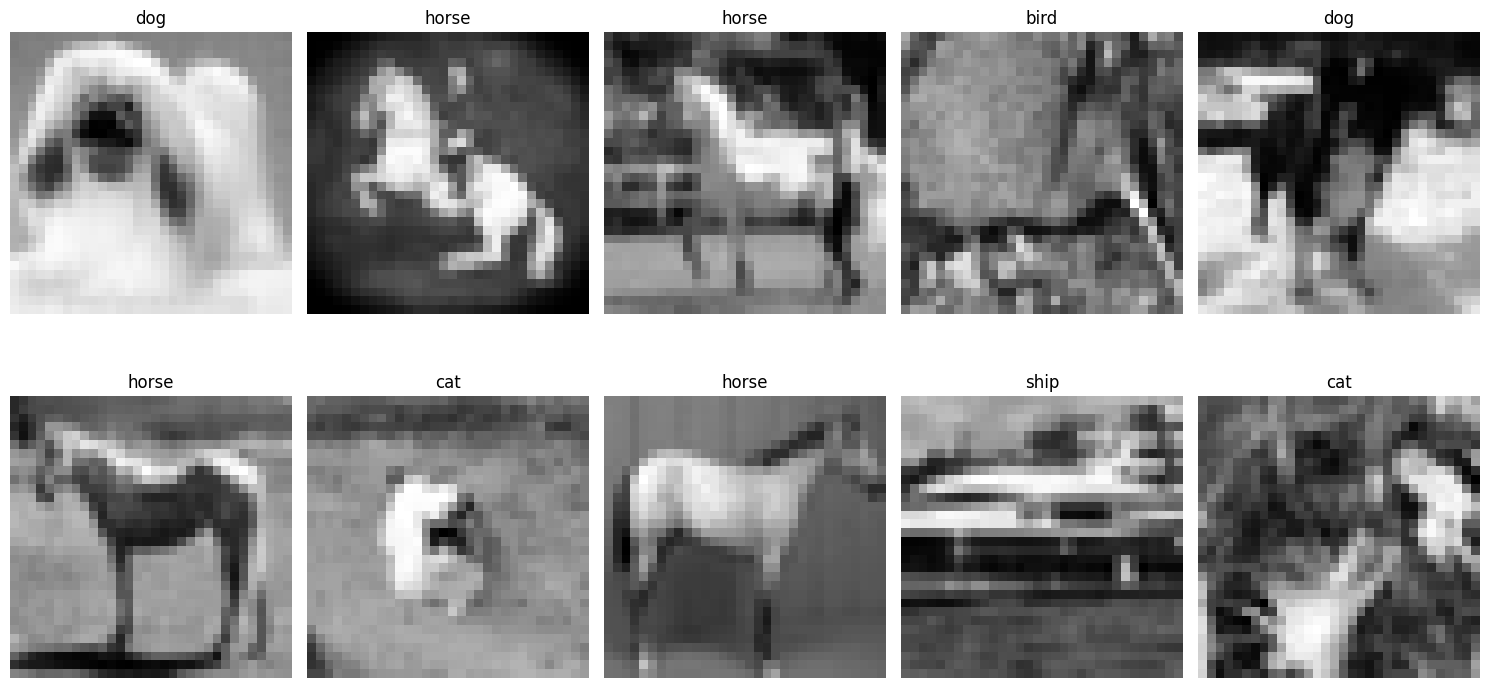

In [10]:
# Get a batch of images and labels
batch = dls.one_batch()

# Number of images to display
num_images = 10

# Create a figure with a grid of subplots (2 rows and 4 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

#Cifar10 classes name
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot each image in the grid
for i in range(num_images):
    row, col = divmod(i, 5)
    ax = axes[row, col]
    img = batch[0][i].cpu().squeeze().numpy()
    label = class_names[batch[1][i].item()]
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

## Gradient Descent

In [11]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
optims2 = [NAG, RMSProp, ADAM]

# Initialize the learners dictionary
learners = {}
time_gd = {}
epochs=20

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    time_gd[opt] = {}
    for model, m in zip(models,mod):
        learners[opt][model] = Learner(dls=dls, model=copy.deepcopy(m), loss_func=CrossEntropyLossFlat(), metrics=accuracy, opt_func=opt2, cbs=[SaveModelCallback()])
        learners[opt][model].to(device)
        learners[opt][model].model.to(device)
        utilsTFG.set_params_to_model(init_weights[model], learners[opt][model].model)


In [12]:
#To check if the models have the same initial parameters
for model in models:
  if utilsTFG.compare_models(learners['NAG'][model], learners['RMSProp'][model]) and utilsTFG.compare_models(learners['NAG'][model], learners['ADAM'][model]) and utilsTFG.compare_models(learners['ADAM'][model], learners['RMSProp'][model]):
    print(f"Mismos parámetros con el modelo {model}.")
  else:
    print("Distintos parámetros.")

Mismos parámetros con el modelo LeNet5.
Mismos parámetros con el modelo ResNet15.
Mismos parámetros con el modelo ResNet57.


### Nesterov

epoch,train_loss,valid_loss,accuracy,time
0,2.557322,2.362046,0.134333,00:03
1,2.264801,2.031330,0.270667,00:03
2,2.036842,1.878210,0.332333,00:03
3,1.868442,1.750524,0.384333,00:03
4,1.724913,1.781469,0.357000,00:03
5,1.598880,1.972106,0.328667,00:03
6,1.496743,2.382446,0.279333,00:03
7,1.405403,1.826953,0.384667,00:03
8,1.318948,1.600459,0.426333,00:03
9,1.240652,1.799691,0.394000,00:03


Better model found at epoch 0 with valid_loss value: 2.3620455265045166.
Better model found at epoch 1 with valid_loss value: 2.031329870223999.
Better model found at epoch 2 with valid_loss value: 1.8782103061676025.
Better model found at epoch 3 with valid_loss value: 1.7505239248275757.
Better model found at epoch 8 with valid_loss value: 1.6004589796066284.
Better model found at epoch 13 with valid_loss value: 1.5581302642822266.
Better model found at epoch 14 with valid_loss value: 1.5552877187728882.
Better model found at epoch 15 with valid_loss value: 1.5459014177322388.
Better model found at epoch 17 with valid_loss value: 1.5362597703933716.


epoch,train_loss,valid_loss,accuracy,time
0,3.411765,2.592582,0.108333,00:03
1,3.168125,2.619870,0.171667,00:03
2,2.929590,2.237064,0.234667,00:03
3,2.698915,1.996702,0.290333,00:03
4,2.486546,2.017437,0.297000,00:03
5,2.307305,1.948782,0.321333,00:03
6,2.152829,1.951624,0.345000,00:03
7,2.016503,1.875805,0.357667,00:03
8,1.909050,1.887344,0.360333,00:03
9,1.811878,1.926664,0.366333,00:03


Better model found at epoch 0 with valid_loss value: 2.5925819873809814.
Better model found at epoch 2 with valid_loss value: 2.2370641231536865.
Better model found at epoch 3 with valid_loss value: 1.9967018365859985.
Better model found at epoch 5 with valid_loss value: 1.948782205581665.
Better model found at epoch 7 with valid_loss value: 1.875805139541626.
Better model found at epoch 11 with valid_loss value: 1.7993662357330322.
Better model found at epoch 13 with valid_loss value: 1.7734384536743164.
Better model found at epoch 17 with valid_loss value: 1.76551353931427.
Better model found at epoch 19 with valid_loss value: 1.758540391921997.


epoch,train_loss,valid_loss,accuracy,time
0,3.482230,2.592250,0.100333,00:04
1,3.278320,2.838319,0.127333,00:04
2,3.066784,2.626659,0.140000,00:04
3,2.860298,2.462223,0.153000,00:04
4,2.747940,2.360227,0.171333,00:04
5,2.644423,2.274129,0.181333,00:04
6,2.547073,2.260707,0.199000,00:04
7,2.489381,2.280104,0.202333,00:04
8,2.448851,2.243684,0.216333,00:04
9,2.400015,2.235524,0.219667,00:04


Better model found at epoch 0 with valid_loss value: 2.592249631881714.
Better model found at epoch 3 with valid_loss value: 2.4622230529785156.
Better model found at epoch 4 with valid_loss value: 2.360227108001709.
Better model found at epoch 5 with valid_loss value: 2.2741286754608154.
Better model found at epoch 6 with valid_loss value: 2.260707139968872.
Better model found at epoch 8 with valid_loss value: 2.2436838150024414.
Better model found at epoch 9 with valid_loss value: 2.2355241775512695.
Better model found at epoch 10 with valid_loss value: 2.195857048034668.
Better model found at epoch 11 with valid_loss value: 2.154883623123169.
Better model found at epoch 12 with valid_loss value: 2.1186628341674805.
Better model found at epoch 16 with valid_loss value: 2.107025384902954.
Better model found at epoch 19 with valid_loss value: 2.1047165393829346.


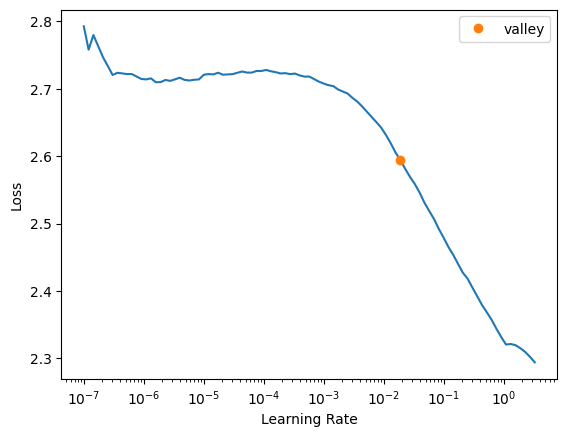

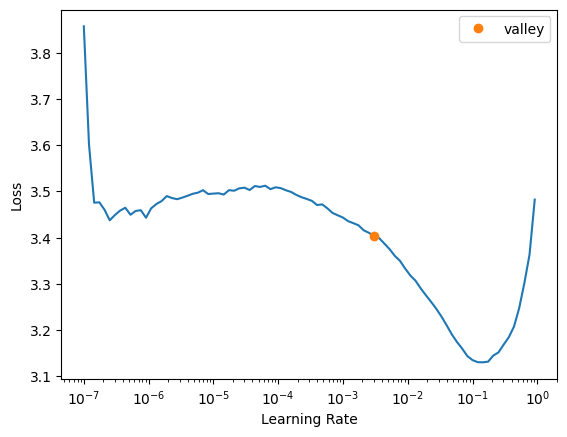

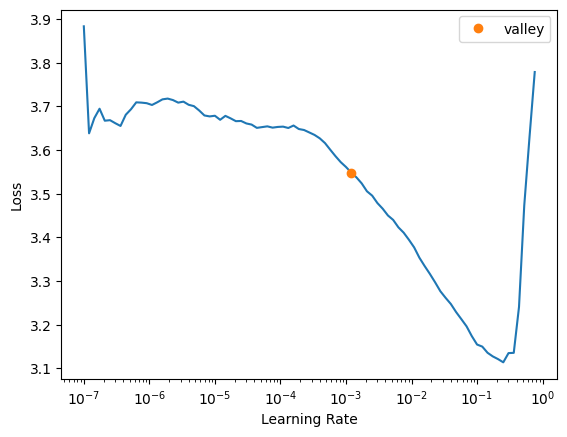

In [13]:
#Run the training and measure the time for each layer
for model, learner in learners['NAG'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['NAG'][model] = end-start



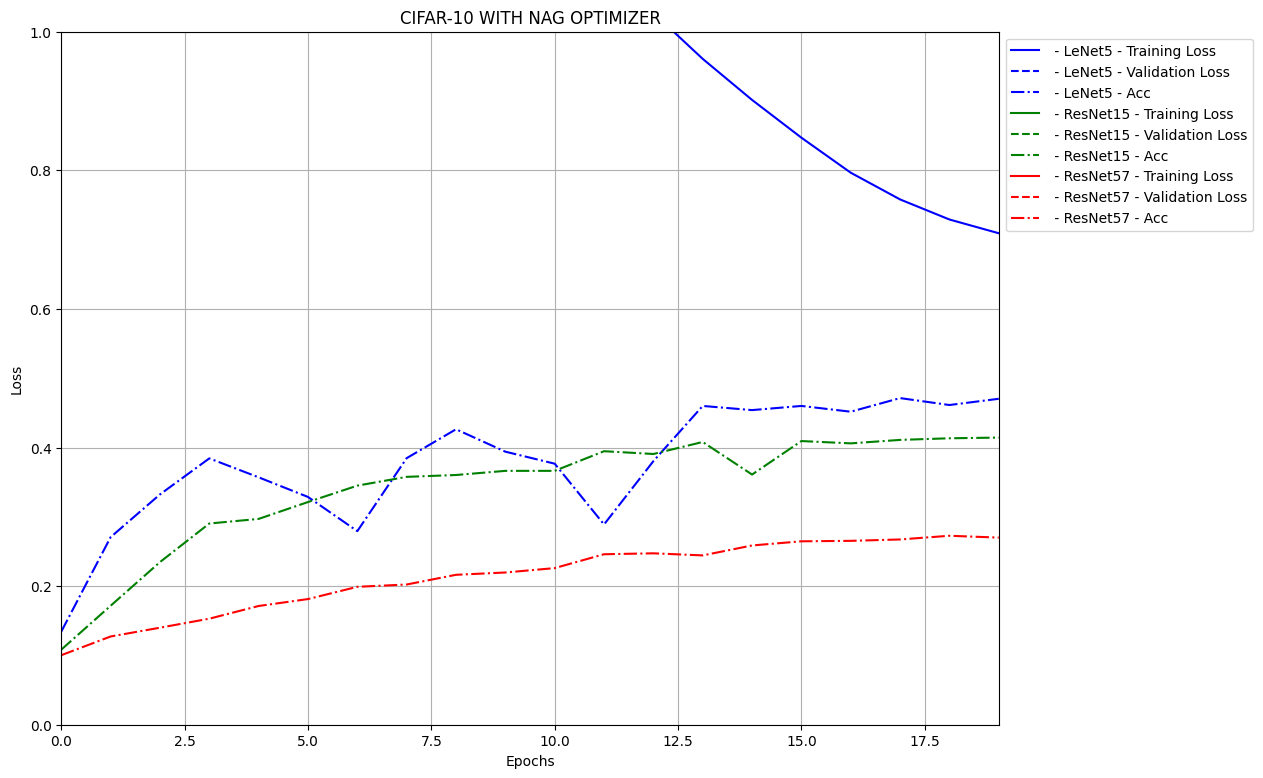

In [14]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['NAG'].values(), title=f'{plot_dataset} WITH NAG OPTIMIZER', names=models, metric=metric)

### RMSProp

epoch,train_loss,valid_loss,accuracy,time
0,1.998809,3.059847,0.206000,00:03
1,1.784547,3.054778,0.263667,00:03
2,1.624987,1.774495,0.400667,00:03
3,1.497230,2.357738,0.313000,00:03
4,1.389248,2.024683,0.358667,00:03
5,1.282429,2.333764,0.348667,00:03
6,1.154989,2.103076,0.410333,00:03
7,1.035190,2.984694,0.329000,00:03
8,0.919151,2.208249,0.451000,00:02
9,0.788342,2.161386,0.468667,00:02


Better model found at epoch 0 with valid_loss value: 3.059847116470337.
Better model found at epoch 1 with valid_loss value: 3.0547783374786377.
Better model found at epoch 2 with valid_loss value: 1.774495005607605.


epoch,train_loss,valid_loss,accuracy,time
0,3.066138,3.211090,0.114667,00:02
1,2.683068,2.780678,0.166667,00:02
2,2.382931,2.076695,0.292333,00:03
3,2.147190,2.462565,0.260333,00:03
4,1.944510,1.877989,0.346000,00:02
5,1.761779,2.230484,0.313333,00:03
6,1.560904,1.858912,0.385333,00:02
7,1.376249,2.370724,0.313667,00:02
8,1.179594,2.001790,0.383000,00:03
9,0.987215,2.050754,0.394000,00:02


Better model found at epoch 0 with valid_loss value: 3.211089611053467.
Better model found at epoch 1 with valid_loss value: 2.7806780338287354.
Better model found at epoch 2 with valid_loss value: 2.076695203781128.
Better model found at epoch 4 with valid_loss value: 1.8779892921447754.
Better model found at epoch 6 with valid_loss value: 1.8589117527008057.


RuntimeError: Exception occured in `SaveModelCallback` when calling event `after_fit`:
	Error(s) in loading state_dict for ResNet15:
	Missing key(s) in state_dict: "bn.weight", "bn.bias", "bn.running_mean", "bn.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer5.0.conv1.weight", "layer5.0.bn1.weight", "layer5.0.bn1.bias", "layer5.0.bn1.running_mean", "layer5.0.bn1.running_var", "layer5.0.conv2.weight", "layer5.0.bn2.weight", "layer5.0.bn2.bias", "layer5.0.bn2.running_mean", "layer5.0.bn2.running_var", "layer5.0.conv3.weight", "layer5.0.bn3.weight", "layer5.0.bn3.bias", "layer5.0.bn3.running_mean", "layer5.0.bn3.running_var", "layer5.0.downsample.0.weight", "layer5.0.downsample.1.weight", "layer5.0.downsample.1.bias", "layer5.0.downsample.1.running_mean", "layer5.0.downsample.1.running_var". 
	Unexpected key(s) in state_dict: "conv2.weight", "conv2.bias", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "bn2.num_batches_tracked", "bn3.weight", "bn3.bias", "bn3.running_mean", "bn3.running_var", "bn3.num_batches_tracked", "fc2.weight", "fc2.bias", "bn4.weight", "bn4.bias", "bn4.running_mean", "bn4.running_var", "bn4.num_batches_tracked", "fc3.weight", "fc3.bias", "conv1.bias". 
	size mismatch for conv1.weight: copying a param with shape torch.Size([6, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 1, 7, 7]).
	size mismatch for bn1.weight: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for bn1.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for bn1.running_mean: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for bn1.running_var: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([120, 400]) from checkpoint, the shape in current model is torch.Size([10, 512]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([10]).

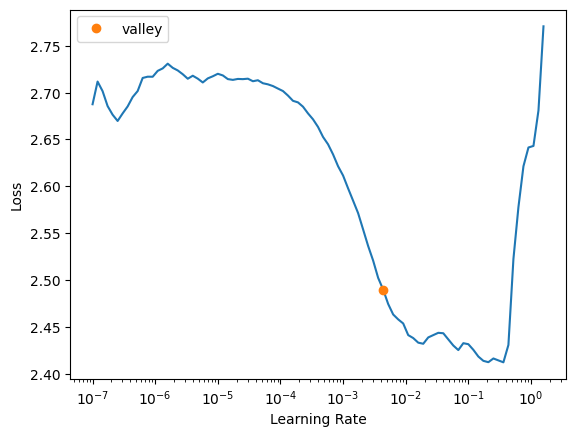

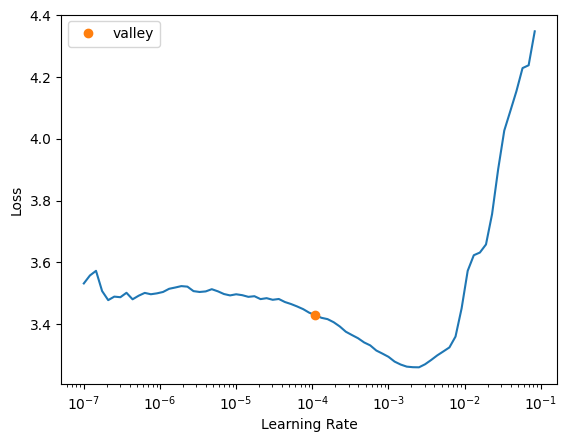

In [15]:
#Run the training and measure the time for each layer
for model, learner in learners['RMSProp'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['RMSProp'][model] = end-start


In [ ]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['RMSProp'].values(), title=f'{plot_dataset} WITH RMSProp OPTIMIZER', names=models, metric=metric)

### Adam

In [ ]:
#Run the training and measure the time for each layer
for model, learner in learners['ADAM'].items():
  try:
    lr=learner.lr_find()
  except:
    lr=0.01
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAM'][model] = end-start


In [ ]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAM'].values(), title=f'{plot_dataset} WITH ADAM OPTIMIZER', lim=2, names=models, metric=metric)

### Save or Load models

In [ ]:
#Save learner with their losses and metrics
for optim in optims:
  for model in models:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{model}_{optim}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump({'learner': learners[optim][model], 'recorder_values': learners[optim][model].recorder.values}, f)


In [ ]:
#Load learner with their losses and metrics
for optim in optims:
  for models in models:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{model}_{optim}.pkl'
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    learners[optim][model], learners[optim][model].recorder.values = data['learner'], data['recorder_values']

### Comparative per models

In [ ]:
#Compare the three optimizers for each layer

learners_lenet =[learners['NAG']['LeNet5'], learners['RMSProp']['LeNet5'], learners['ADAM']['LeNet5']]
learners_resnet = [learners['NAG']['ResNet15'], learners['RMSProp']['ResNet15'], learners['ADAM']['ResNet15']]
learners_resnet57 = [learners['NAG']['ResNet57'], learners['RMSProp']['ResNet57'], learners['ADAM']['ResNet57']]

names=['NAG', 'RMSProp', 'ADAM']
utilsTFG.plot_learners_training(learners_lenet, title=f'{plot_dataset} WITH LeNet5', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_resnet, title=f'{plot_dataset} WITH ResNet15', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_resnet57, title=f'{plot_dataset} WITH ResNet57', names=names, metric=metric)

### Generalization

In [ ]:
models =['LeNet5', 'ResNet15'] #Sometimes it overrides the array
#Run the model in the test set
for optim in optims:
  for model in models:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][model].model.eval()
    learners[optim][model].eval()
    preds, targs = learners[optim][model].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    # Calculate bal_accuracy
    accuracy = utilsTFG.balanced_accuracy_func(preds, targs)

    #Calculate loss
    loss = utilsTFG.err_param_w_model(learners[optim][model].model, test_dl, mode = 'test')
    #loss = CrossEntropyLossFlat()(preds, targs)


    print(f"Optimizer: {optim}, Model: {model}, Loss: {loss}, Accuracy: {accuracy}")

## Metaheuristics

In [ ]:
#Initialise dictionaries
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}
time_mh = {}

#Initialise the population to have the same values for all the MH
for model,m in zip(models,mod):
  population[model] = []
  fitness[model] = []
  mh_learners[model] = Learner(dls, model=copy.deepcopy(m), loss_func=CrossEntropyLossFlat(),  cbs=[SaveModelCallback()])
  mh_learners[model].to(device)
  mh_learners[model].model.to(device)
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[model].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.init_weights_glorot)

    # Add the reinitialized model to the population list
    population[model].append(utilsTFG.get_params_from_model(model_copy))

    fitness[model].append(utilsTFG.err_param_w_model(model_copy, dls))

#More initialisation
for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}
  time_mh[alg] = {}

max_evals=4200
max_evals_shade=200
max_ls=10


### Genetic Algorithms

In [ ]:
#Genetic Algorithm working as supposed to (terrible performance)
#results['GA'] = {}
#for layer in n_layers:
#  start = time.perf_counter()
#  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), fitness[layer], dls, 4000, mh_learners[layer])
#  end = time.perf_counter()
#  time_mh['GA'][layer] = end-start

### SHADE

In [ ]:
#Runing SHADE algorithm

results['SHADE'] = {}
for model in models:
  start = time.perf_counter()
  results['SHADE'][model] = utilsTFG.SHADE_ej(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), pop_size,max_evals, len(population[model][0]), dls,  model=mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE'][model] = end-start


In [ ]:
#Validate the models obtained.
fitness_valid['SHADE'] = {}
for model in models:
  fitness_valid['SHADE'][model] = []
  for ind in results['SHADE'][model][5]:
    fitness_valid['SHADE'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))

In [ ]:
#compare train and valid and select the best generalizing model.
for model in models:
  print(f"Training error of SHADE for {model} model: {results['SHADE'][model][6]}")
  print(f"Validation error of SHADE for {model} model: {fitness_valid['SHADE'][model]}")
  dif = np.array(fitness_valid['SHADE'][model]) - np.array(results['SHADE'][model][6])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE'][model])
  best['SHADE'][model] = results['SHADE'][model][5][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")

  print("\n")

In [ ]:
#Save the mh results
file_path = f'/notebooks/saved_models/SHADE_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE'], f)

### SHADE-ILS

In [ ]:
# Running SHADE-ILS algorithm
results['SHADE-ILS'] = {}
for model in models:
  start = time.perf_counter()
  results['SHADE-ILS'][model] = utilsTFG.SHADE_ILS(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS'][model] = end-start


In [ ]:
#Validation error
fitness_valid['SHADE-ILS'] = {}
for model in models:
  fitness_valid['SHADE-ILS'][model] = []
  for ind in results['SHADE-ILS'][model][3]:
    fitness_valid['SHADE-ILS'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))

In [ ]:
#Compare train and valid
for model in models:
  print(f"Training error of SHADE-ILS for {model} model: {results['SHADE-ILS'][model][2]}")
  print(f"Validation error of SHADE-ILS for {model} model: {fitness_valid['SHADE-ILS'][model]}")
  dif = np.array(fitness_valid['SHADE-ILS'][model]) - np.array(results['SHADE-ILS'][model][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS'][model])
  best['SHADE-ILS'][model] = results['SHADE-ILS'][model][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

In [ ]:
#Save the mh results
file_path = f'/notebooks/saved_models/SHADE_ILS_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS'], f)

### SHADE-GD

In [ ]:
# Running SHADE algorithm with GD
results['SHADE-GD'] = {}
for model in models:
  start = time.perf_counter()
  results['SHADE-GD'][model] = utilsTFG.SHADE_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE-GD'][model] = end-start


In [ ]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for model in models:
  fitness_valid['SHADE-GD'][model] = []
  for ind in results['SHADE-GD'][model][3]:
    fitness_valid['SHADE-GD'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))

In [ ]:
#Compare train and valid
for model in models:
  print(f"Training error of SHADE-GD for {model} model: {results['SHADE-GD'][model][2]}")
  print(f"Validation error of SHADE-GD for {model} model: {fitness_valid['SHADE-GD'][model]}")
  dif = np.array(fitness_valid['SHADE-GD'][model]) - np.array(results['SHADE-GD'][model][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-GD'][model])
  best['SHADE-GD'][model] = results['SHADE-GD'][model][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

In [ ]:
#Save the mh results
file_path = f'/notebooks/saved_models/SHADE_GD_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-GD'], f)

### SHADE-ILS-GD

In [ ]:
# SHADE-ILS-GD
results['SHADE-ILS-GD'] = {}
for model in models:
  start = time.perf_counter()
  results['SHADE-ILS-GD'][model] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]),  max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][model] = end-start


In [ ]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for model in models:
  fitness_valid['SHADE-ILS-GD'][model] = []
  for ind in results['SHADE-ILS-GD'][model][3]:
    fitness_valid['SHADE-ILS-GD'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))

In [ ]:
#Compare train and valid
for model in models:
  print(f"Training error of SHADE-ILS-GD for {model} model: {results['SHADE-ILS-GD'][model][2]}")
  print(f"Validation error of SHADE-ILS-GD for {model} model: {fitness_valid['SHADE-ILS-GD'][model]}")
  dif = np.array(fitness_valid['SHADE-ILS-GD'][model]) - np.array(results['SHADE-ILS-GD'][model][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS-GD'][model])
  best['SHADE-ILS-GD'][model] = results['SHADE-ILS-GD'][model][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

In [ ]:
#Save the mh results
file_path = f'/notebooks/saved_models/SHADE_ILS_GD_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS-GD'], f)

### Save or load

In [ ]:
#Save the mh results
file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
#Load the trained mh results
file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'rb') as f:
    results = pickle.load(f)

### Comparison between MH

In [ ]:
#Saving training loss for better manipulation
training = {}
for mh in algs:
  training[mh] = {}
for model in models:
  training['SHADE'][model] = results['SHADE'][model][6]
  training['SHADE-ILS'][model] = results['SHADE-ILS'][model][2]
  training['SHADE-GD'][model] = results['SHADE-GD'][model][2]
  training['SHADE-ILS-GD'][model] = results['SHADE-ILS-GD'][model][2]

In [ ]:
from fastai.metrics import accuracy
#Calculate accuracy
acc = {}
for mh in algs:
  acc[mh] = {}
  for model in models:
    acc[mh][model] = []
    ind = 5 if mh == 'SHADE' else 3
    for ind in results[mh][model][ind]:
      utilsTFG.set_params_to_model(ind, mh_learners[model].model)
      mh_learners[model].model.eval()
      mh_learners[model].eval()
      preds, targs = mh_learners[model].get_preds(dl=dls.valid)
      targs = targs.long().squeeze()

      # Calculate balanced_accuracy
      acc[mh][model].append(accuracy(preds, targs))

In [ ]:
#Comparing the different layers version of the same MH
for alg in algs:
  utilsTFG.plot_mh_mlp_training(training[alg], fitness_valid[alg], acc[alg], layers=models, names=models, title=f'TRAINING IN {plot_dataset} WITH {alg}')

In [ ]:
#Comparing the different MH for the same layer number

names= ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
train = {}
ac = {}
valid = {}
for model in models:
  train[model] = {}
  ac[model] = {}
  valid[model] = {}
  for alg in algs:
    train[model][alg] = training[alg][model]
    ac[model][alg] = acc[alg][model]
    valid[model][alg] = fitness_valid[alg][model]
  utilsTFG.plot_mh_mlp_training(train[model], valid[model], ac[model],  layers=names, names=names, title=f'TRAINING IN {plot_dataset} WITH {model}')

### Generalization

In [ ]:
#Run the model in the test set
for mh in algs:
  for model in models:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    utilsTFG.set_params_to_model(best[mh][model], mh_learners[model].model)
    mh_learners[model].model.eval()
    mh_learners[model].eval()
    preds, targs = mh_learners[model].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    #Calculate accuracy

    accur = utilsTFG.balanced_accuracy_func(preds, targs)


    loss = utilsTFG.err_param_w_model(mh_learners[model].model, test_dl, mode = 'test')

    print(f"Optimizer: {mh}, Model: {model}, Loss: {loss}, Accuracy: {accur}")

## Time comparison

In [ ]:
#Compare times for each algorithm and layer

#GD
for alg, time_model in time_mh.items():
  for model, time in time_model.items():
    print(f'Time consumed by {alg} training with {model}: {time:.04f} seconds')

#MH
for optims, time_model in time_gd.items():
  for model, time in time_model.items():
    print(f'Time consumed by {optims} training with {model}: {time:.04f} seconds')

